# Coursework1: Convolutional Neural Networks 

## instructions

Please submit a version of this notebook containing your answers **together with your trained model** on CATe as CW2.zip. Write your answers in the cells below each question.

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so. 

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [4]:
!pip install torch torchvision

## Introduction

For this coursework you will implement one of the most commonly used model for image recognition tasks, the Residual Network. The architecture is introduced in 2015 by Kaiming He, et al. in the paper ["Deep residual learning for image recognition"](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). 
<br>

In a residual network, each block contains some convolutional layers, plus "skip" connections, which allow the activations to by pass a layer, and then be summed up with the activations of the skipped layer. The image below illustrates a building block in residual networks.

![](resnet-block.png)

Depending on the number of building blocks, resnets can have different architectures, for example ResNet-50, ResNet-101 and etc. Here you are required to build ResNet-18 to perform classification on the CIFAR-10 dataset, therefore your network will have the following architecture:

In [0]:
from google.colab import drive
drive.mount('/content/drive')

## Part 1 (40 points)

In this part, you will use basic pytorch operations to define the 2D convolution, max pooling operation, linear layer as well as 2d batch normalization. 

### YOUR TASK

- implement the forward pass for Conv2D, MaxPool2D, Linear and BatchNorm2d
- You are **NOT** allowed to use the torch.nn modules

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math 

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height HH and width WW.

        Parameters:
        - w: Filter weights of shape (F, C, HH, WW)
        - b: Biases, of shape (F,)
        - kernel_size: Size of the convolving kernel
        - stride: The number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: The number of pixels that will be used to zero-pad the input.
        """

        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.Bbias = bias
        self.out_channels = out_channels
        self.in_channels = in_channels

        # Make kerne_size a tuple if it is not a tuple
        if isinstance(kernel_size, int):
          self.kernel_size = (kernel_size, kernel_size)
        else:
          self.kernel_size = kernel_size

        # Make padding a tuple if it is not a tuple
        if isinstance(padding, int):
          self.padding = (padding, padding)
        else:
          self.padding = padding

        # Make stride a tuple if it is not a tuple    
        if isinstance(stride, int):
          self.stride = (stride, stride)
        else:
          self.stride = stride

        # Assign the device. GPU if available
        if torch.cuda.is_available():
          device = torch.device('cuda:0')
        else:
          device = torch.device('cpu')

        # Instantiate the weights thorugh kaiming (He) initialisation
        self.weights = torch.zeros(size=(self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1]),
                             requires_grad = True, device = device)
        nn.init.kaiming_normal_(self.weights)

        # Instantiate the biases as zeros
        if self.Bbias: 
          self.bias = torch.zeros([self.out_channels,],
                                  requires_grad = True, device = device)
        else: 
          self.bias = None

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """

        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        [N, _, H , W] = x.shape
        
        # Find the output height (Hout), width (Wout) and number of channels Cout. 
        Hout = (H-self.kernel_size[0]+2*self.padding[0])/(self.stride[0]) + 1
        Wout = (W-self.kernel_size[1]+2*self.padding[1])/(self.stride[1]) + 1
        Cout = self.out_channels
        
        # Int (floor) the output size for compatibility. (We do not dilate the 
        # image in the case Hout and Wout are floating point numbers as is done in Conv2d, 
        # out of the scope of the coursework)
        if not Wout.is_integer() or not Hout.is_integer:
          # In the future, an extra padding could be added to make sure that no 
          # data is lost
          pass
        Hout = int(Hout)
        Wout = int(Wout)

        # Unfold X 
        Xunfold = F.unfold(x, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride)
        # Flatten the kernels
        kernels_flat = self.weights.view(self.out_channels, -1)
        # Matrix multiplication along the number of channels
        res = kernels_flat @ Xunfold
        # Reshape the result into the desired output dimension
        res = res.view(N, self.out_channels, Hout, Wout)

        # Add bias if necessary
        if self.Bbias:
          res += self.bias.view(1,self.out_channels,1,1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return res

In [0]:
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: the size of the window to take a max over
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Make kernel_size a tuple if needed
        if isinstance(kernel_size, int):
          self.kernel_size = (kernel_size, kernel_size)
        else:
          self.kernel_size = kernel_size

        # Stride is the same as the kernel_size during max_pooling
        self.stride = kernel_size

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Find the output height (Hout), width (Wout) and number of channels Cout. 
        [N, C, H , W] = x.shape
        
        Hout = (H-self.kernel_size[0])/(self.stride[0]) + 1
        Wout = (W-self.kernel_size[1])/(self.stride[0]) + 1
        Cout = C

        # Int (floor) the output size for compatibility. (We do not dilate the 
        # image in the case Hout and Wout are floating point numbers as is done in Conv2d, 
        # out of the scope of the coursework)
        if not Wout.is_integer() or not Hout.is_integer:
          # In the future, an extra padding could be added to make sure that no 
          # data is lost
          pass
        Hout = int(Hout)
        Wout = int(Wout)

        # Unfold X
        Xunfold = F.unfold(x, kernel_size=self.kernel_size, stride=self.stride)
        # Reshape X in order to allow the kernel_size dimension to be isolated
        tempX = Xunfold.view(N, C, self.kernel_size[0]*self.kernel_size[1], int(H*W/(self.kernel_size[0]*self.kernel_size[1])))
        # Max pool and reduce dimension kernel_size**2 into 1
        poolX, _ = torch.max(tempX,dim=2)
        # Reshape to output
        out = poolX.view(N,C, int(H/self.kernel_size[0]), int(W/self.kernel_size[1]))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [0]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Assign input variables
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.Bbias = bias

        # Assign the device. GPU if available
        if torch.cuda.is_available():
          self.device = torch.device('cuda:0')
        else:
          self.device = torch.device('cpu')

        # Instantiate weights through kaiming (He) initialisation
        self.weights = torch.zeros(size=(self.in_channels, self.out_channels), 
                             requires_grad = True, device = self.device)
        nn.init.kaiming_normal_(self.weights)

        # Initialise bias if required
        if self.Bbias: 
          self.bias = torch.zeros(size=(self.out_channels,), 
                                  requires_grad = True, device = self.device)
        else: 
          self.bias = None

        # Kaiming initialisation of the biases if present
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Linear product of weights and inputs
        out = x @ self.weights
        # Add bias if required
        if self.Bbias:
          out += self.bias

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [0]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        """
        An implementation of a Batch Normalization over a mini-batch of 2D inputs.

        The mean and standard-deviation are calculated per-dimension over the
        mini-batches and gamma and beta are learnable parameter vectors of
        size num_features.

        Parameters:
        - num_features: C from an expected input of size (N, C, H, W).
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: momentum – the value used for the running_mean and running_var
        computation. Default: 0.1
        - gamma: the learnable weights of shape (num_features).
        - beta: the learnable bias of the module of shape (num_features).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Save input variables
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        # Initial running mean does not exist
        self.running_mean = None
        self.running_var = None

        # Assign the device. GPU if available
        if torch.cuda.is_available():
          device = torch.device('cuda:0')
        else:
          device = torch.device('cpu')

        # Initialise learnable parameter gamma to ones
        self.gamma = torch.ones(size=(1,self.num_features,1,1),
                                 requires_grad=True, device = device)
        # Initialise learnable parameter gamma to zeros
        self.beta = torch.zeros(size=(1,self.num_features,1,1),
                                 requires_grad=True, device = device) 

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        During training this layer keeps running estimates of its computed mean and
        variance, which are then used for normalization during evaluation.
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data of shape (N, C, H, W) (same shape as input)
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        #       (be aware of the difference for training and testing)          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Only calculate the mean and variance of the input during training to 
        # assign new moving averages
        if self.training:
          mean_tmp = torch.mean(x, dim= (0,2,3))
          mean_tmp = mean_tmp.view((1,x.shape[1],1,1))
          var_tmp = torch.var(x, dim = (0,2,3), unbiased = True) # Torch.var is unbiased by default
          var_tmp = var_tmp.view((1,x.shape[1],1,1))

          with torch.no_grad():
            if self.running_mean is None:
              # For the first iteration during training running (.) is current (.)
              self.running_mean = mean_tmp
              self.running_var = var_tmp
            else:
              # Calculate running mean and variance with momentum
              self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*mean_tmp
              self.running_var = (1-self.momentum)*self.running_var + self.momentum*var_tmp

        # Calculate the normalised unweighted output
        unweighted_x = (x - self.running_mean)/torch.sqrt(self.running_var + self.eps)

        if self.training:
          # Un-normalise with gradient
          x = self.gamma*unweighted_x  + self.beta
        else:
          with torch.no_grad():
            # Un-normalise without gradient during test
            x = self.gamma*unweighted_x + self.beta

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return x

## Part 2


In this part, you will train a ResNet-18 defined on the CIFAR-10 dataset. Code for training and evaluation are provided. 

### Your Task

1. Train your network to achieve the best possible test set accuracy after a maximum of 10 epochs of training.

2. You can use techniques such as optimal hyper-parameter searching, data pre-processing

3. If necessary, you can also use another optimizer

4. **Answer the following question:**
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? 

**Answer to Question 4**

There are too many parameters in the network to perform a complete exhaustive search as is performed in naive hyperparameter tuning methods such as cross-validation. A better solution to this "curse of dimensionality" could be tackled through the use of evolutionary strategies (Jaderberg, et al, 2017) or bayesian optimisation (Dewancker, et al, 2015). Indeed, a narrow grid search could be implemented after finding an "optimal" hyperparameter setting configuration through the aforementioned approaches, in order to fine-tune around the approximal optima.  

Max Jaderberg, et al. “Population based training of neural networks.” arXiv preprint arXiv:1711.09846 (2017).

Ian Dewancker, et al. "Bayesian Optimization Primer." https://app.sigopt.com/static/pdf/SigOpt_Bayesian_Optimization_Primer.pdf (2015)

In [0]:
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F

Next, we define ResNet-18:

In [0]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  # BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True),
                                  nn.Dropout(p=0.07), 
                                  Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel),
                                  # BatchNorm2d(outchannel),
                                  nn.Dropout(p=0.07)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel),
                                          # BatchNorm2d(outchannel), 
                                          nn.Dropout(p=0.07)) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out



    # define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(64),
                                  # BatchNorm2d(64), 
                                  nn.ReLU(),
                                  nn.Dropout(p=0.07))
        
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2d(4)
        self.fc = nn.Linear(512, num_classes)
        # self.fc = Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
    
def ResNet18():
    return ResNet(ResidualBlock)

### Loading dataset
We will import images from the [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) library <br>
First, we need to define the alterations (transforms) we want to perform to our images - given that transformations are applied when importing the data. <br>
Define the following transforms using the torchvision.datasets library -- you can read the transforms documentation [here](https://pytorch.org/docs/stable/torchvision/transforms.html): <br>
1. Convert images to tensor
2. Normalize mean and std of images with values:mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]

In [0]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

transform_train = T.Compose([
                T.RandomHorizontalFlip(p=0.5), 
                T.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3), # 0.5p
                #T.RandomRotation(5, resample=False, expand=False, center=None),
                T.RandomCrop(size = 30, padding = 2),
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

transform_test_eval = T.Compose([
                  T.ToTensor(),
                  T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

##############################################################
#                       END OF YOUR CODE                     #
##############################################################

Now load the dataset using the transform you defined above, with batch_size = 64<br>
You can check the documentation [here](https://pytorch.org/docs/stable/torchvision/datasets.html)
Then create data loaders (using DataLoader from torch.utils.data) for the training and test set

In [10]:
##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

data_dir = './data'

NUM_TRAIN = 49000

cifar10_train = dset.CIFAR10(data_dir, train=True, download=True,
                             transform=transform_train)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10(data_dir, train=True, download=True,
                           transform=transform_test_eval)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform_test_eval)
loader_test = DataLoader(cifar10_test, batch_size=64)

##############################################################
#                       END OF YOUR CODE                     #       
##############################################################

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [0]:
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
print_every = 200
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))



def train_part(model, optimizer, epochs=1, scheduler = None):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print(len(loader_train))
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                check_accuracy(loader_val, model)
                print()
        if scheduler != None:
          scheduler.step()

In [12]:
# code for optimising your network performance

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################
# We augmented data through crops, random perspectives and horizontal flips
# Normalised the images
# Added dropout p = 0.07
# Added a scheduler which reduces the learning rate further. Gamma = 0.5, step_size = 3
# Reduced initial Adam learning rate to 0.0008
##############################################################
#                       END OF YOUR CODE                     #
##############################################################

# 88.8% Accuracy on test set

# define and train the network
model = ResNet18()
optimizer = optim.Adam(model.parameters(), lr = 0.0008)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.5)
train_part(model, optimizer, epochs = 10, scheduler=scheduler)

# report test set accuracy

check_accuracy(loader_test, model)

# save the model
torch.save(model.state_dict(), 'model.pt')

766
Epoch: 0, Iteration 0, loss = 3.2963
Checking accuracy on validation set
Got 127 / 1000 correct (12.70)

Epoch: 0, Iteration 200, loss = 1.4912
Checking accuracy on validation set
Got 403 / 1000 correct (40.30)

Epoch: 0, Iteration 400, loss = 1.9257
Checking accuracy on validation set
Got 478 / 1000 correct (47.80)

Epoch: 0, Iteration 600, loss = 1.3911
Checking accuracy on validation set
Got 491 / 1000 correct (49.10)

766
Epoch: 1, Iteration 0, loss = 0.9419
Checking accuracy on validation set
Got 545 / 1000 correct (54.50)

Epoch: 1, Iteration 200, loss = 1.0760
Checking accuracy on validation set
Got 664 / 1000 correct (66.40)

Epoch: 1, Iteration 400, loss = 1.2272
Checking accuracy on validation set
Got 663 / 1000 correct (66.30)

Epoch: 1, Iteration 600, loss = 0.9930
Checking accuracy on validation set
Got 687 / 1000 correct (68.70)

766
Epoch: 2, Iteration 0, loss = 0.7667
Checking accuracy on validation set
Got 622 / 1000 correct (62.20)

Epoch: 2, Iteration 200, loss =

## Part 3

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions**: 

1. Compare the feature maps from low-level layers to high-level layers, what do you observe? 

2. Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance?

3. What are the other possible ways to analyse the performance of your network?

**YOUR ANSWER FOR PART 3 HERE**

A:

**Question 1**

As we progress into the latter stages, feature maps become more unique, showcasing that abstraction increases along the deep layers. In the first layers the feature maps are much more informative: Objects are detectable in the first feature map whilst parts of objects are activated in specific smaller layers. For example, the last layers indicate if like "PAWS" or "EYES" are visible in the image. The shift from interpretability to abstraction reflects the fact that the CNN attempts to extract the learnable principle components of the input image (it is effectively an autoencoder). Finally, the layers in the feature maps become more sparse, resembling a binary one-hot vector space (cells are active or inactive are inactive, whilst in the first layers the feature maps have more continuous representations). This may well be due to the max-pooling principle. Indeed this representation is more convenient for the FFNN in the following stages.

On another note. If we look at the feature maps in the first layer we can see how there are many similar feature maps as so to being able to classify them into boxes. This resembles the fact that many filters converge to similar results (due to random weight initialisation).

**Question 2**

 - Training Log: 
Both the training loss and the validation accuracy are valuable parameters used during hyperparameter tuning. Indeed these improve during training. However, training was observed to be quite unstable. From this, the learning rate was reduced from its deafault value (1e-03) to 8e-04, as well as through the addition of a scheduler. Notwithstanding, there is still a lot of learnable capability in the CNN: During the 10 epochs of training the loss continues to reduces, even along the last epoch. Furthermore, the validation accuracy increases parallel to this, meaning that there is no overfitting. The epoch number could therefore be increased.

 - Test Set:
 From the accuracy retreived during testing, it was found that there was a considerable drop in accuracy w.r.t the validation set. For this reason, dropout was implemented as a measure to enforce generalisation. This improved test set performance by almost 3%.

 - Feature Maps: 
The feature maps in the last layer are relatively sparse. This is a positive indication as it infers that the CNN is less ambiguous about the relationship extracted from the image. First layers are consistent with each other. We can kind of group the representations of the first layer together. This showcases that the filters can actually converge to similar values due to gradient descent and weight initialisation. Also shows that there is redundancy between different filters and that weight initialisation is of crucial importance (in order to allow the CNN to properly cover the sparse representation of the image).

- Improvements
Judging on the number of classes (10) an accuracy of 88.8% is relatively high. Nevertheless there is still a lot of learning to be done (validation accuracy is still increasing at the 10th Epoch). Could also use more data (further augment data by creating noisy copies of the training samples). Learning is still fuzzy and unstable even after reducing the learning rate, so we could potentially stabilise by increasing the batch size, allowing retreival of unbiased gradient estimates. Additionally, we could plot the validation errors against number of epochs as well as the training error to evaluate overfitting. This information could be used to support the selection of the dropout probability by augmentation or reduction throuhg observation of overfitting and underfittiong respectively. 

**Question 3**

Accuracy is not the most informative measure in this case as it does not consider the performance of each class. Other scores such as F1 could be computed (per class), allowing a measure which compromises between precision and recall. Oversampling measures could be implemented further to account with any possible imbalance within classes. Also, the accuracy of the model might not be hollistically good. Indeed comparison with benchmark CNNs or other ML methods such as SVMs could be more informative in order to quantitabely determine the model performance. Another thing which could be done is to test the architecture in different datasets i.e. MNIST or ImageNET.

<Figure size 432x288 with 0 Axes>

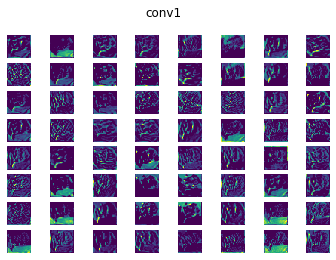

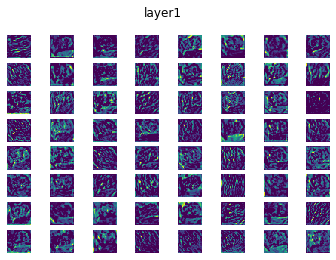

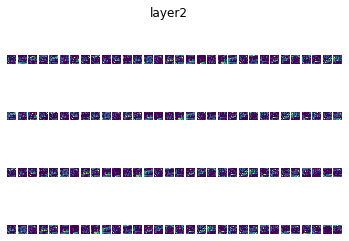

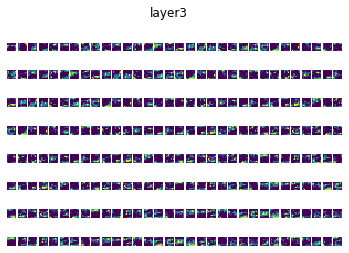

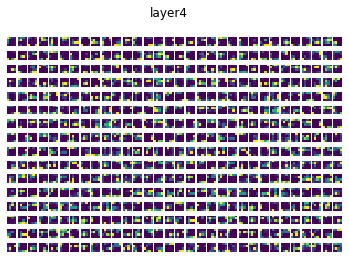

In [23]:
#!pip install matplotlib

import matplotlib.pyplot as plt

plt.tight_layout()


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model, l).register_forward_hook(get_activation(l))
    
    
data, _ = cifar10_test[0]
data = data.unsqueeze_(0).to(device = device, dtype = dtype)

output = model(data)



for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32
        
    nrows = act.size(0) // ncols
    
    fig, axarr = plt.subplots(nrows, ncols)
    fig.suptitle(l)


    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')